<a href="https://colab.research.google.com/github/sumu97/Data-Science-Cheat-Code/blob/main/Kospi_Market_Analysis_sumu97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#코스피 동향분석 및 예측 - sumu97

###개요
 - 코스피 지수의 동향을 예측하여, 선물옵션을 통한 단기적 수익실현 및 투자지표로서의 활용이 가능하도록 합니다.
 - 추후 동일한 모델을 부동산 시장 등에 적용시키기 위해, 데이터에 맞춰 쉽게 변형할 수 있도록 작성합니다.
 - 두 개 이상의 예측 모델을 활용하여 그 결과를 토대로 서로의 예측을 개선할 수 있게 합니다.
 - 아리마 분석으로 Feature 수치를 대략적으로 예측하고, 예측된 데이터를 토대로 Random Forest를 활용해 Target Value를 구합니다.

## 1. 데이터

In [2]:
%%capture
from google.colab import drive
import io
import pandas as pd
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWheiajOhcZhJJOEywyD3yD0vyzVJpJyGbgH3NYMX4dGBFgcT0xACLk


In [3]:
# 데이터
import datetime
import numpy as np

def get_data(NAME,col):
  # 1. 데이터 가져오기
  df = pd.read_csv('drive/MyDrive/Project/Data_For_Kospi/' + NAME + '.csv')

  # 2. 종가, 거래량, 변동% 제외한 Feature 제거 (중복 Issue 가능성)
  df = df.drop(['오픈','고가','저가'], axis=1)

  # 3. 컬럼명 변경 (원본 데이터마다 Columns 다름, 오류처리구문 추가)
  columns_volp = ['date' , col + '_' + 'enpr' , col + '_' + 'volm' , col + '_' + 'chag']
  columns_volm = ['date' , col + '_' + 'enpr' , col + '_' + 'chag']
  try:
    df.columns = columns_volp
  except:
    df.columns = columns_volm

  # 4. 자료형 변경
  for col in df.columns:
    temp_list = []
    for i in df[col]:
      
      try:
        temp = i.replace('년','') # ER : SILVER ('sv_enpr',) 23.925 에서 에러발생 / float를 replace 하다보니 문제 / 츄라이로 넘겨서 해결
        temp = temp.replace('월','')
        temp = temp.replace('일','')
        temp = temp.replace(' ','-') # 수정 / Debug
        temp = temp.replace(',','')
        temp = temp.replace('K','000')
        temp = temp.replace('%','')
      except:
        temp_list.append(i) # 첨부터 float인 자료형을 list에 저장 / ER : append(temp) 해놓고 뭐가문젠지 한참 찾았네..
        continue # ER : 컬럼에 리스트 적용시 길이가 달라 에러발생 / 아래 츄라이문 하면서 중복적용된게 문제 / 컨티뉴로 돌려보내서 해결
        # ER : 뒷쪽 구문 먹어버려서 'sv_enpr' 에 의미가 다른 값이 들어감
      try:
        temp = float(temp)
        temp_list.append(temp) # float 로 변경된 자료형을 list에 저장
      except:
        try:
          #print(col, i, temp)
          temp = datetime.datetime.strptime(temp, '%Y-%m-%d').date()
          temp_list.append(temp) # datetime 로 변경된 자료형을 list에 저장
        except:
          temp = np.nan
          temp_list.append(temp) # NaN 으로 변경된 자료형을 list에 저장
    df[col] = temp_list # 변경된 리스트를 col 에 저장

  print(df.shape) # Debug code / 으아아 같은기간 긁었는데 뭐가이렇게 달라

  # 5. 데이터프레임으로 반환
  return df

gd = get_data('GOLD','gd') # 금 시세
sv = get_data('SILVER','sv') # 은 시세
ob = get_data('OIL_BRENT','ob') # 브렌트유 시세
ow = get_data('OIL_WTI','ow') # WTI유 시세
sp = get_data('S&P','sp') # 미국 증시 S&P 500 지수
kd = get_data('KOSDAQ','kd') # 코스닥
kp = get_data('KOSPI','kp') # 코스피(Target)
kr = get_data('KR10','kr') # 한국 10년 국채 수익률
us = get_data('US10','us') # 미국 10년 국채 수익률
jk = get_data('JPY_KRW','jk') # 엔 - 원 환율
uk = get_data('USD_KRW','uk') # 달러 - 원 환율

gd.set_index('date', inplace = True)
sv.set_index('date', inplace = True)
ob.set_index('date', inplace = True)
ow.set_index('date', inplace = True)
sp.set_index('date', inplace = True)
kd.set_index('date', inplace = True)
kp.set_index('date', inplace = True)
kr.set_index('date', inplace = True)
us.set_index('date', inplace = True)
jk.set_index('date', inplace = True)
uk.set_index('date', inplace = True)

df = gd.join(sv, how='outer').join(ob, how='outer').join(ow, how='outer').join(sp , how='outer').join(kd , how='outer').join(kp , how='outer').join(kr , how='outer').join(us , how='outer').join(jk , how='outer').join(uk , how='outer')

(2642, 4)
(3140, 4)
(2604, 4)
(2635, 4)
(2537, 4)
(2485, 4)
(2484, 4)
(3168, 3)
(3012, 3)
(2632, 3)
(2632, 3)


In [4]:
# 결측치가 너무 많은 (1500 이상인) Feature 삭제
df = df.drop(['sp_volm','kd_volm','kp_volm'], axis = 1)

In [5]:
# 나머지 결측치는 선형 보간 (interpolation)
df_intp = df.interpolate()

In [6]:
# 보간 후에도 결측치 남아있는 행 삭제 (상위 2행, 시계열 데이터에 영향 주지 않음)
df = df_intp.dropna()

In [7]:
# 중복 값 있는지 확인 -> 없음
df.T.duplicated()

gd_enpr    False
gd_volm    False
gd_chag    False
sv_enpr    False
sv_volm    False
sv_chag    False
ob_enpr    False
ob_volm    False
ob_chag    False
ow_enpr    False
ow_volm    False
ow_chag    False
sp_enpr    False
sp_chag    False
kd_enpr    False
kd_chag    False
kp_enpr    False
kp_chag    False
kr_enpr    False
kr_chag    False
us_enpr    False
us_chag    False
jk_enpr    False
jk_chag    False
uk_enpr    False
uk_chag    False
dtype: bool

## 2. Arima 분석 실증 Test

In [8]:
df.columns

Index(['gd_enpr', 'gd_volm', 'gd_chag', 'sv_enpr', 'sv_volm', 'sv_chag',
       'ob_enpr', 'ob_volm', 'ob_chag', 'ow_enpr', 'ow_volm', 'ow_chag',
       'sp_enpr', 'sp_chag', 'kd_enpr', 'kd_chag', 'kp_enpr', 'kp_chag',
       'kr_enpr', 'kr_chag', 'us_enpr', 'us_chag', 'jk_enpr', 'jk_chag',
       'uk_enpr', 'uk_chag'],
      dtype='object')

In [9]:
df_enpr = df['sv_enpr']

In [10]:
df_enpr

date
2011-10-04    29.7950
2011-10-05    30.3170
2011-10-06    31.9700
2011-10-07    30.9580
2011-10-09    31.6850
               ...   
2021-10-28    24.1200
2021-10-29    23.9490
2021-10-30    23.8945
2021-10-31    23.8400
2021-11-01    23.9250
Name: sv_enpr, Length: 3509, dtype: float64

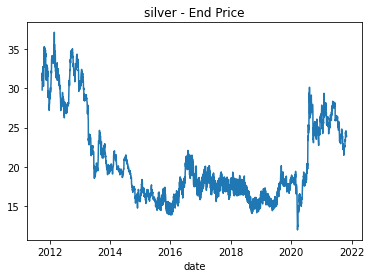

In [11]:
import matplotlib.pyplot as plt
df_enpr.plot()
plt.title('silver - End Price')
plt.show()

In [12]:
df_enpr

date
2011-10-04    29.7950
2011-10-05    30.3170
2011-10-06    31.9700
2011-10-07    30.9580
2011-10-09    31.6850
               ...   
2021-10-28    24.1200
2021-10-29    23.9490
2021-10-30    23.8945
2021-10-31    23.8400
2021-11-01    23.9250
Name: sv_enpr, Length: 3509, dtype: float64

In [13]:
step = 10 # 테스트 데이터 분리 할 일자 수
test_df = df_enpr.drop(df_enpr.index[-1 * step :-1])
test_df = test_df.drop(test_df.index[-1])
test_df

date
2011-10-04    29.795
2011-10-05    30.317
2011-10-06    31.970
2011-10-07    30.958
2011-10-09    31.685
               ...  
2021-10-18    23.264
2021-10-19    23.883
2021-10-20    24.445
2021-10-21    24.170
2021-10-22    24.449
Name: sv_enpr, Length: 3499, dtype: float64

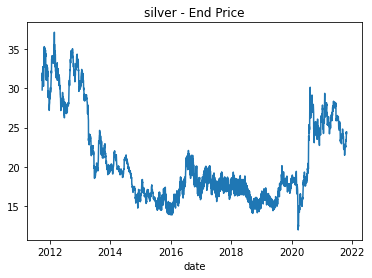

In [14]:
import matplotlib.pyplot as plt
test_df.plot()
plt.title('silver - End Price')
plt.show()

In [15]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(test_df.values, order = (5,1,2))
# AR = 3, 차분 = 1, MA = 2 파라미터로 ARIMA 모델을 학습한다.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
# ARIMA 모델 학습
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3498
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2489.170
Method:                       css-mle   S.D. of innovations              0.493
Date:                Tue, 09 Nov 2021   AIC                           4996.341
Time:                        11:18:18   BIC                           5051.780
Sample:                             1   HQIC                          5016.127
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.005     -0.397      0.691      -0.011       0.007
ar.L1.D.y      0.0499      0.070      0.710      0.477      -0.088       0.188
ar.L2.D.y     -0.6488      0.025    -26.201      0.0

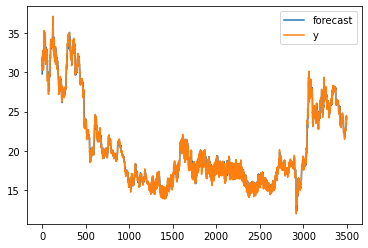

In [17]:
# 학습 데이터에 대한 예측 결과
fig = model_fit.plot_predict()

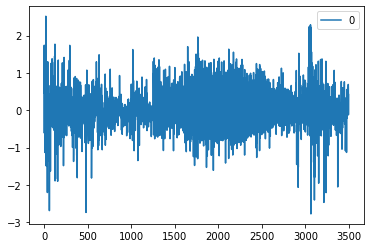

In [18]:
# 실제값과 예측값 사이의 오차 변동
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [19]:
# 모델 평가
forecast_data = model_fit.forecast(steps=step) 

test_df_c = df_enpr[len(df_enpr) - step:]
test_df_c

date
2021-10-23    24.4510
2021-10-24    24.4530
2021-10-25    24.5920
2021-10-26    24.0880
2021-10-27    24.1910
2021-10-28    24.1200
2021-10-29    23.9490
2021-10-30    23.8945
2021-10-31    23.8400
2021-11-01    23.9250
Name: sv_enpr, dtype: float64

In [20]:
# 마지막 5월의 예측 데이터
pred_y = forecast_data[0].tolist()

# 실제 5월의 데이터
test_y = test_df_c.values

# 마지막 5월의 예측 데이터 최소값
pred_y_lower = []

# 마지막 5월의 예측 데이터 최대값
pred_y_upper = []

In [21]:
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

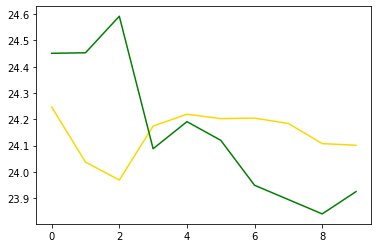

In [22]:
# 2,1,2 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

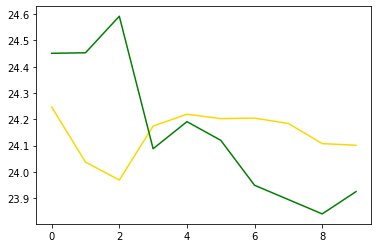

In [23]:
# 10,1,2 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

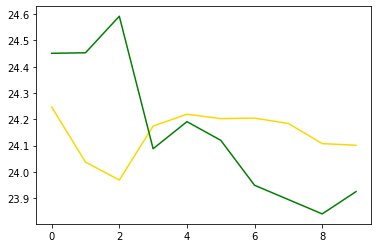

In [24]:
# 5,1,2 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

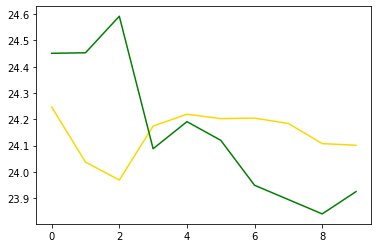

In [25]:
# 7,1,2 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

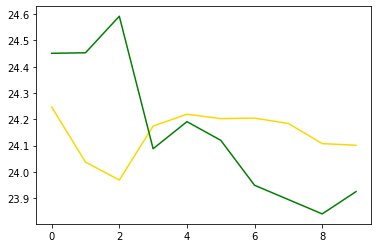

In [26]:
# 2,1,5 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

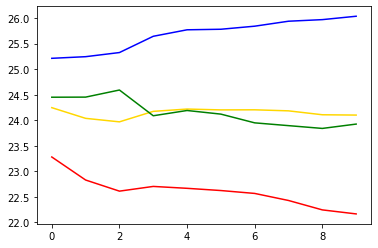

In [27]:
# 2,1,5 모델이 예측한 가격 그래프 (30)
plt.plot(pred_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

In [28]:
# 위의 내용을 df_enpr, steps 로 함수화
def arima(col,step=10): # df.gd_enpr,10
  from statsmodels.tsa.arima_model import ARIMA
  import statsmodels.api as sm
  test_df = col.drop(col.index[-1 * step :-1])
  test_df = test_df.drop(test_df.index[-1])

  model = ARIMA(test_df.values, order = (5,1,2))
  model_fit = model.fit(trend = 'c', full_output = True, disp = True)

  forecast_data = model_fit.forecast(steps=step) 

  test_df_c = col[len(col) - step:]
  test_df_c

  # 예측 데이터
  pred_y = forecast_data[0].tolist()

  # 실제 데이터
  test_y = test_df_c.values

  # 예측 데이터 최소값
  pred_y_lower = []

  # 예측 데이터 최대값
  pred_y_upper = []

  for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)
  
  	
  #fig = plt.figure(figsize=(5,5))

  # 모델이 예측한 가격 그래프
  plt.plot(pred_y, color = 'gold')

  # 모델이 예측한 최저 가격 그래프
  #plt.plot(pred_y_lower, color = 'red')

  # 모델이 예측한 최고 가격 그래프
  #plt.plot(pred_y_upper, color = 'blue')

  # 실제 가격 그래프
  plt.plot(test_y, color = 'green')


In [29]:
len(df.columns)

26

In [30]:
df.columns[1:2]

Index(['gd_volm'], dtype='object')

Progress:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianI

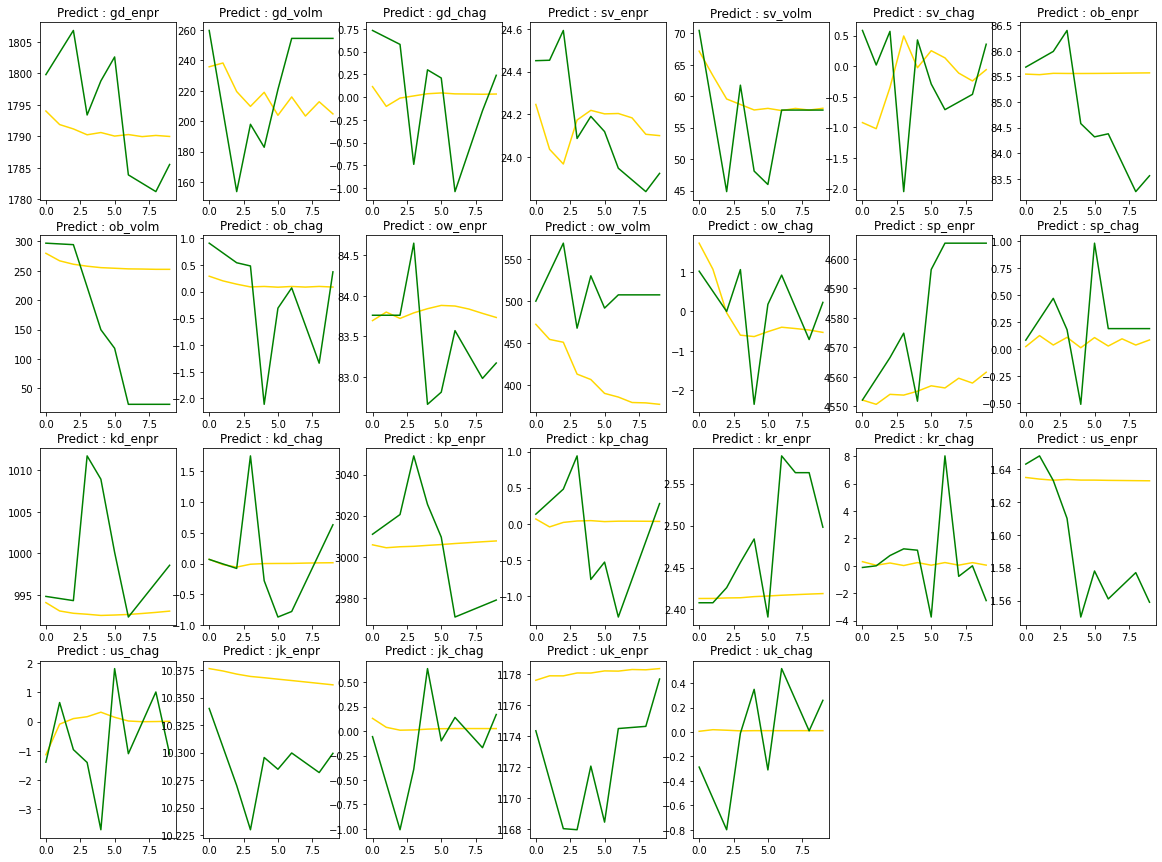

In [32]:
from tqdm import notebook
import time 

grid = (1,3)
n = 0

fig = plt.figure(figsize=(20,15))
for i in notebook.tqdm(df.columns, desc='Progress'):
    n += 1
    plt.subplot(4,7,n)
    plt.title("Predict : "+ i)
    arima(df[i])


plt.show()

ARIMA 모델이 Volume 을 제외하면 적절한 수준으로 예측하는것을 확인했다.\
 변동이 너무 커 정상적으로 예측하지 못하는 거래량은 Feature에서 제거한다.

In [33]:
df = df.drop(['gd_volm','sv_volm','ob_volm','ow_volm'], axis=1)

In [34]:
len(df.columns)

22

In [35]:
df.columns

Index(['gd_enpr', 'gd_chag', 'sv_enpr', 'sv_chag', 'ob_enpr', 'ob_chag',
       'ow_enpr', 'ow_chag', 'sp_enpr', 'sp_chag', 'kd_enpr', 'kd_chag',
       'kp_enpr', 'kp_chag', 'kr_enpr', 'kr_chag', 'us_enpr', 'us_chag',
       'jk_enpr', 'jk_chag', 'uk_enpr', 'uk_chag'],
      dtype='object')

##3. ARIMA 분석 적용 - 예측 데이터프레임 생성

In [36]:
# 데이터 축소.. 필요한가?

In [37]:
# ARIMA 예측 함수
def arima(col,step=10): # df.gd_enpr,10
  from statsmodels.tsa.arima_model import ARIMA
  import statsmodels.api as sm

  model = ARIMA(col.values, order = (5,1,2))
  model_fit = model.fit(trend = 'c', full_output = True, disp = True)

  forecast_data = model_fit.forecast(steps=step) 

  # 예측 데이터
  pred_y = forecast_data[0].tolist()
  return pred_y

In [38]:
df.kp_enpr[-30:]

date
2021-10-03    2990.675000
2021-10-04    2976.422500
2021-10-05    2962.170000
2021-10-06    2908.310000
2021-10-07    2959.460000
2021-10-08    2956.300000
2021-10-09    2946.320000
2021-10-10    2936.340000
2021-10-11    2926.360000
2021-10-12    2916.380000
2021-10-13    2944.410000
2021-10-14    2988.640000
2021-10-15    3015.060000
2021-10-16    3012.266667
2021-10-17    3009.473333
2021-10-18    3006.680000
2021-10-19    3029.040000
2021-10-20    3013.130000
2021-10-21    3007.330000
2021-10-22    3006.160000
2021-10-23    3010.953333
2021-10-24    3015.746667
2021-10-25    3020.540000
2021-10-26    3049.080000
2021-10-27    3025.490000
2021-10-28    3009.550000
2021-10-29    2970.680000
2021-10-30    2973.433333
2021-10-31    2976.186667
2021-11-01    2978.940000
Name: kp_enpr, dtype: float64

In [39]:
arima(df.kp_enpr,step=30)

[2979.3001657206005,
 2981.8252901701894,
 2982.7782443200335,
 2983.8460705495636,
 2984.4833100968317,
 2985.1365821550953,
 2985.5556558550484,
 2985.9866515496133,
 2986.347792288207,
 2986.713296815479,
 2987.0596940895225,
 2987.4139822135703,
 2987.764971495595,
 2988.121089560766,
 2988.4778027681728,
 2988.837276323245,
 2989.1974331324336,
 2989.558799540411,
 2989.920486569571,
 2990.282594198116,
 2990.644780681664,
 2991.00707434052,
 2991.3693581326706,
 2991.731650334066,
 2992.093918435714,
 2992.4561759375442,
 2992.8184167332643,
 2993.180649250024,
 2993.542873656167,
 2993.9050942697586]

In [40]:
step = 10 # 테스트 데이터 분리 할 일자 수



df.columns

Index(['gd_enpr', 'gd_chag', 'sv_enpr', 'sv_chag', 'ob_enpr', 'ob_chag',
       'ow_enpr', 'ow_chag', 'sp_enpr', 'sp_chag', 'kd_enpr', 'kd_chag',
       'kp_enpr', 'kp_chag', 'kr_enpr', 'kr_chag', 'us_enpr', 'us_chag',
       'jk_enpr', 'jk_chag', 'uk_enpr', 'uk_chag'],
      dtype='object')

In [41]:
df = df.drop(['kp_enpr', 'kp_chag'], axis=1)